In [ ]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 33.2 MB/s eta 0:00:00


I want to change my approach completely
I have 3 folders(Basic, AWGN, Noisy)
The basic folder has my original images
The AWGN folder has my AWGN noise-added images
the Noisy folder has My Noisy random-noise added images
each of these(Basic,AWGN,Noisy) folders has a test folder inside that
inside the test, I have three folders (COVID, normal, and viral)
I want to calculate noise metrics(PSNR, MSE, SSIM)
for all these methods based on the Basic folder as a reference images
methods = ["Mean", "Median", "Gaussian," "Bilateral," "Weiner," "Wavelet," "Fourier"]
and plot bar chart for each of (covid, normal, viral) folders
for example, I want to start a plot bar chart for applying methods on AWGN after compare with the Basic folder corresponding images to achieve  PSNR value next plot a bar chart with different colors for each method
announcements
I have  a lot image in every folder I need calculate for ten first image and finally set average as representing value
the image name is not the same in different folders just order shows the same image so for comparison between Basic and AWGn consider the images order number

at the end I have 2 comparison(Basic and AWGN, Basic and Noisy) for each  have three metrics(PSNR, MSE,SSIM) bar chart plot so Finally I have 6 Plot
in each plot, I need 7 method comparisons with different colors and tag bar chart(the value of each metrics is the average of 10 first images)


Traditional methods for denoising

Five I'll adapt the code to calculate the metrics (PSNR and SSIM) for only the first 5 images in each folder, average the results for each denoising method, and save 30 bar charts (15 for PSNR and 15 for SSIM) comparing the methods. I'll make sure to update the code accordingly.

# Mount Google Drive
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import pandas as pd



# Define paths
base_path = "/content/drive/MyDrive/CS415Project/chest_xray"  # Update this to match your Drive structure
processed_train_path = os.path.join(base_path, "processed_train")
processed_train_noisy_path = os.path.join(base_path, "processed_train_noisy")
comparison_output_path = os.path.join(base_path, "comparison")

# Create output folder for charts
os.makedirs(comparison_output_path, exist_ok=True)

# Define methods for denoising
def apply_denoising(image, method):
    if method == "Mean":
        return cv2.blur(image, (5, 5))
    elif method == "Median":
        return cv2.medianBlur(image, 5)
    elif method == "Gaussian":
        return cv2.GaussianBlur(image, (5, 5), 1.5)
    elif method == "Bilateral":
        return cv2.bilateralFilter(image, 9, 75, 75)
    elif method == "Weiner":
        from scipy.signal import wiener
        filtered = wiener(image, (5, 5))
        return np.clip(filtered, 0, 255).astype(np.uint8)
    elif method == "Wavelet":
        import pywt
        coeffs = pywt.wavedec2(image, 'haar', level=2)
        coeffs_thresh = [coeffs[0]]
        for details in coeffs[1:]:
            coeffs_thresh.append(tuple(pywt.threshold(c, value=30, mode='soft') for c in details))
        return pywt.waverec2(coeffs_thresh, 'haar').astype(np.uint8)
    elif method == "Fourier":
        f = np.fft.fft2(image)
        fshift = np.fft.fftshift(f)
        rows, cols = image.shape
        crow, ccol = rows // 2, cols // 2
        mask = np.zeros((rows, cols), np.uint8)
        mask[crow-30:crow+30, ccol-30:ccol+30] = 1
        fshift *= mask
        f_ishift = np.fft.ifftshift(fshift)
        img_back = np.fft.ifft2(f_ishift)
        return np.abs(img_back).astype(np.uint8)
    else:
        raise ValueError(f"Unknown method: {method}")

# Define metrics
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    return 10 * np.log10(max_pixel ** 2 / mse)

def calculate_ssim(original, denoised):
    return ssim(original, denoised, data_range=original.max() - original.min())

# Define denoising methods
methods = ["Mean", "Median", "Gaussian", "Bilateral", "Weiner", "Wavelet", "Fourier"]

# Process folders
folders = ["BACTERIA", "NORMAL", "VIRUS"]
noises = ["gaussian", "impulse", "poisson", "salt_pepper", "speckle"]

# Initialize results
results = []

for folder in folders:
    original_path = os.path.join(processed_train_path, folder)
    noisy_folder_path = os.path.join(processed_train_noisy_path, folder)

    for noise in noises:
        noisy_path = os.path.join(noisy_folder_path, f"{folder}_noisy_{noise}")

        psnr_results = {method: [] for method in methods}
        ssim_results = {method: [] for method in methods}

        # Process first 5 images
        original_images = sorted(os.listdir(original_path))[:5]
        noisy_images = sorted(os.listdir(noisy_path))[:5]

        for orig_name, noisy_name in zip(original_images, noisy_images):
            orig_img = cv2.imread(os.path.join(original_path, orig_name), cv2.IMREAD_GRAYSCALE)
            noisy_img = cv2.imread(os.path.join(noisy_path, noisy_name), cv2.IMREAD_GRAYSCALE)

            if orig_img is None or noisy_img is None:
                continue

            for method in methods:
                denoised_img = apply_denoising(noisy_img, method)
                psnr_value = calculate_psnr(orig_img, denoised_img)
                ssim_value = calculate_ssim(orig_img, denoised_img)
                psnr_results[method].append(psnr_value)
                ssim_results[method].append(ssim_value)

        # Calculate averages
        avg_psnr = {method: np.mean(psnr_results[method]) for method in methods}
        avg_ssim = {method: np.mean(ssim_results[method]) for method in methods}

        results.append({
            "folder": folder,
            "noise": noise,
            "psnr": avg_psnr,
            "ssim": avg_ssim
        })

        # Create bar charts
        for metric, metric_name in zip([avg_psnr, avg_ssim], ["PSNR", "SSIM"]):
            plt.figure(figsize=(10, 6))
            plt.bar(metric.keys(), metric.values(), color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2"])
            plt.xlabel("Denoising Methods")
            plt.ylabel(metric_name)
            plt.title(f"{metric_name} Comparison - {folder} - {noise}")
            plt.xticks(rotation=45)
            chart_path = os.path.join(comparison_output_path, f"{folder}_{noise}_{metric_name}.png")
            plt.savefig(chart_path)
            plt.close()

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(base_path, "denoising_comparison_results.csv"), index=False)

print(f"Results saved to {base_path}/denoising_comparison_results.csv")
print(f"Charts saved in {comparison_output_path}")


/content/drive/MyDrive/CS415Project/chest_xray/
  ├── processed_train/
  │   ├── BACTERIA/
  │   ├── NORMAL/
  │   └── VIRUS/
  ├── processed_train_noisy/
  │   ├── BACTERIA_noisy_gaussian/
  │   ├── BACTERIA_noisy_poisson/
  │   ├── NORMAL_noisy_gaussian/
  │   └── ...
  ├── comparison/  # Charts will be saved here

/content/drive/MyDrive/CS415Project/chest_xray/
    ├── processed_train/
    │    └── BACTERIA/
    │          ├── original_image_1.png
    │          └── original_image_2.png
    │    └── NORMAL/
    │          ├── original_image_1.png
    │          └── original_image_2.png
    │    └── VIROS/
    │          ├── original_image_1.png
    │          └── original_image_2.png
    ├── processed_train_noisy/
         ├── BACTERIA_noisy_gaussian/
         │     ├── noisy_image_1.png
         │     └── noisy_image_2.png
         ├── BACTERIA_noisy_impulse/
         │     ├── noisy_image_1.png
         │     └── noisy_image_2.png
         ...
         ├── NORMAL_noisy_gaussian/
         │     ├── noisy_image_1.png
         │     └── noisy_image_2.png
         ├──NORMAL_noisy_impulse/
         │     ├── noisy_image_1.png
         │     └── noisy_image_2.png
          ....
         ├── VIROS_noisy_gaussian/
         │     ├── noisy_image_1.png

         │     └── noisy_image_2.png
         ├── VIROS_noisy_impulse/
         │     ├── noisy_image_1.png
         │     └── noisy_image_2.png
          ....

PSNR and SSIM


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define denoising methods
def apply_denoising(image, method):
    if method == "Mean":
        return cv2.blur(image, (5, 5))
    elif method == "Median":
        return cv2.medianBlur(image, 5)
    elif method == "Gaussian":
        return cv2.GaussianBlur(image, (5, 5), 2.5)
    elif method == "Bilateral":
        return cv2.bilateralFilter(image, 7, 50, 15)
    elif method == "Weiner":
        return wiener_filter(image)
    elif method == "Wavelet":
        return wavelet_denoise(image)
    elif method == "Fourier":
        return fourier_denoise(image)
    else:
        raise ValueError("Unknown method")

# Wiener filter
def wiener_filter(image):
    from scipy.signal import wiener
    filtered = wiener(image, (5, 5))
    filtered = np.nan_to_num(filtered, nan=0.0)
    return np.clip(filtered, 0, 255).astype(np.uint8)

# Wavelet denoising
def wavelet_denoise(image):
    import pywt
    coeffs = pywt.wavedec2(image, 'haar', level=2)
    coeffs_thresh = [coeffs[0]]
    for details in coeffs[1:]:
        coeffs_thresh.append(tuple(pywt.threshold(c, value=30, mode='soft') for c in details))
    return pywt.waverec2(coeffs_thresh, 'haar').astype(np.uint8)

# Fourier denoising
def fourier_denoise(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1
    fshift *= mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back).astype(np.uint8)

# Base folder paths
base_path = '/content/drive/MyDrive/CS415Project/chest_xray'
original_path = os.path.join(base_path, 'processed_train/NORMAL')
noisy_base_path = os.path.join(base_path, 'processed_train_noisy')

# Noise types and methods
noise_types = ['gaussian', 'impulse', 'poisson', 'salt_pepper', 'speckle']
methods = ["Mean", "Median", "Gaussian", "Bilateral", "Weiner", "Wavelet", "Fourier"]

# Output folder for comparisons
output_folder = os.path.join(base_path, 'comparison-images')
os.makedirs(output_folder, exist_ok=True)

# Process NORMAL folder
for noise_type in noise_types:
    noisy_folder_path = os.path.join(noisy_base_path, f'NORMAL_noisy_{noise_type}')

    if not os.path.exists(noisy_folder_path):
        print(f"Folder not found: {noisy_folder_path}")
        continue

    # Get the first image from the original and noisy folders
    original_images = sorted(os.listdir(original_path))[:1]
    noisy_images = sorted(os.listdir(noisy_folder_path))[:1]

    for noisy_img_name, orig_img_name in zip(noisy_images, original_images):
        orig_img_path = os.path.join(original_path, orig_img_name)
        noisy_img_path = os.path.join(noisy_folder_path, noisy_img_name)

        orig_img = cv2.imread(orig_img_path, cv2.IMREAD_GRAYSCALE)
        noisy_img = cv2.imread(noisy_img_path, cv2.IMREAD_GRAYSCALE)

        if orig_img is None or noisy_img is None:
            print(f"Error loading images: {orig_img_name}, {noisy_img_name}")
            continue

        # Resize noisy image to match original dimensions
        noisy_img_resized = cv2.resize(noisy_img, (orig_img.shape[1], orig_img.shape[0]))

        # Apply denoising methods
        denoised_images = [apply_denoising(noisy_img_resized, method) for method in methods]

        # Prepare the figure for visualization
        fig, axes = plt.subplots(1, 9, figsize=(20, 6))  # 1 row, 9 columns

        # Original image
        axes[0].imshow(orig_img, cmap='gray')
        axes[0].set_title('Original')
        axes[0].axis('off')

        # Noisy image
        axes[1].imshow(noisy_img_resized, cmap='gray')
        axes[1].set_title(f'Noisy ({noise_type})')
        axes[1].axis('off')

        # Denoised images
        for i, (method, denoised_img) in enumerate(zip(methods, denoised_images), start=2):
            axes[i].imshow(denoised_img, cmap='gray')
            axes[i].set_title(f'{method}')
            axes[i].axis('off')

        # Adjust spacing to reduce gaps between images
        plt.subplots_adjust(wspace=0.05, hspace=0.05)

        # Save the comparison figure
        save_path = os.path.join(output_folder, f'NORMAL_{noise_type}_comparison.png')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        plt.close()

        print(f"Saved comparison for noise type '{noise_type}' to {save_path}")


/usr/local/lib/python3.10/dist-packages/scipy/signal/_signaltools.py:1659: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)


ModuleNotFoundError: No module named 'pywt'

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define denoising methods
def apply_denoising(image, method):
    if method == "Mean":
        return cv2.blur(image, (5, 5))
    elif method == "Median":
        return cv2.medianBlur(image, 5)
    elif method == "Gaussian":
        return cv2.GaussianBlur(image, (5, 5), 2.5)
    elif method == "Bilateral":
        return cv2.bilateralFilter(image, 7, 50, 15)
    elif method == "Weiner":
        return wiener_filter(image)
    elif method == "Wavelet":
        return wavelet_denoise(image)
    elif method == "Fourier":
        return fourier_denoise(image)
    else:
        raise ValueError("Unknown method")

# Wiener filter
def wiener_filter(image):
    from scipy.signal import wiener
    filtered = wiener(image, (5, 5))
    filtered = np.nan_to_num(filtered, nan=0.0)
    return np.clip(filtered, 0, 255).astype(np.uint8)

# Wavelet denoising
def wavelet_denoise(image):
    import pywt
    coeffs = pywt.wavedec2(image, 'haar', level=2)
    coeffs_thresh = [coeffs[0]]
    for details in coeffs[1:]:
        coeffs_thresh.append(tuple(pywt.threshold(c, value=30, mode='soft') for c in details))
    return pywt.waverec2(coeffs_thresh, 'haar').astype(np.uint8)

# Fourier denoising
def fourier_denoise(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1
    fshift *= mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back).astype(np.uint8)

# Define metrics
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def calculate_ssim(original, denoised):
    from skimage.metrics import structural_similarity as ssim
    return ssim(original, denoised, data_range=denoised.max() - denoised.min())

def calculate_mse(original, denoised):
    return np.mean((original - denoised) ** 2)

# Assign colors to methods
method_colors = {
    "Mean": "#FF5733",
    "Median": "#33FF57",
    "Gaussian": "#337BFF",
    "Bilateral": "#FF33F6",
    "Weiner": "#F3FF33",
    "Wavelet": "#33FFF1",
    "Fourier": "#7D33FF"
}

# Paths
base_path = '/content/drive/MyDrive/CS415Project/chest_xray/processed_train'
folders = ['BACTERIA', 'NORMAL', 'VIRUS']
methods = ["Mean", "Median", "Gaussian", "Bilateral", "Weiner", "Wavelet", "Fourier"]

# Output folders
output_path = os.path.join(base_path, 'Comparison-Images')
os.makedirs(output_path, exist_ok=True)

for metric in ['MSE', 'PSNR', 'SSIM']:
    os.makedirs(os.path.join(base_path, f'compare_{metric}'), exist_ok=True)

# Prepare Excel writer
excel_data = []

# Process each folder
for folder in folders:
    folder_path = os.path.join(base_path, f'processed_train/{folder}')
    noisy_folder_path = os.path.join(base_path, f'processed_train_noisy/{folder}')

    if not os.path.exists(folder_path) or not os.path.exists(noisy_folder_path):
        print(f"Missing folder: {folder}!")
        continue

    original_images = sorted(os.listdir(folder_path))[:1]
    noise_types = sorted(os.listdir(noisy_folder_path))

    for noise_type in noise_types:
        noise_path = os.path.join(noisy_folder_path, noise_type)
        noisy_images = sorted(os.listdir(noise_path))[:1]

        for orig_name, noisy_name in zip(original_images, noisy_images):
            orig_path = os.path.join(folder_path, orig_name)
            noisy_path = os.path.join(noise_path, noisy_name)

            original = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)
            noisy = cv2.imread(noisy_path, cv2.IMREAD_GRAYSCALE)

            # Resize to match dimensions
            noisy_resized = cv2.resize(noisy, (original.shape[1], original.shape[0]))

            # Calculate metrics
            metrics = {'Method': [], 'MSE': [], 'PSNR': [], 'SSIM': []}

            for method in methods:
                denoised = apply_denoising(noisy_resized, method)
                metrics['Method'].append(method)
                metrics['MSE'].append(calculate_mse(original, denoised))
                metrics['PSNR'].append(calculate_psnr(original, denoised))
                metrics['SSIM'].append(calculate_ssim(original, denoised))

            # Save metrics for Excel
            for i, method in enumerate(metrics['Method']):
                excel_data.append([folder, noise_type, method, metrics['MSE'][i], metrics['PSNR'][i], metrics['SSIM'][i]])

            # Create bar charts
            for metric in ['MSE', 'PSNR', 'SSIM']:
                plt.figure(figsize=(8, 5))
                plt.bar(metrics['Method'], metrics[metric], color=[method_colors[m] for m in metrics['Method']])
                plt.title(f"{metric} Comparison for {folder} ({noise_type})")
                plt.xlabel("Methods")
                plt.ylabel(metric)
                plt.xticks(rotation=45)
                plt.tight_layout()

                save_chart_path = os.path.join(base_path, f'compare_{metric}', f'{folder}_{noise_type}_{metric}.png')
                plt.savefig(save_chart_path)
                plt.close()
                print(f"Saved {metric} bar chart for {folder} - {noise_type}")

# Save to Excel
excel_df = pd.DataFrame(excel_data, columns=['Folder', 'Noise Type', 'Method', 'MSE', 'PSNR', 'SSIM'])
excel_output_path = os.path.join(base_path, 'Denoising_Comparison.xlsx')
excel_df.to_excel(excel_output_path, index=False)
print(f"Excel file saved to {excel_output_path}")


Missing folder: BACTERIA!
Missing folder: NORMAL!
Missing folder: VIRUS!
Excel file saved to /content/drive/MyDrive/CS415Project/chest_xray/Denoising_Comparison.xlsx


I have this structure
  ├── processed_train/
│ ├── BACTERIA/
│ ├── NORMAL/
│ ├── VIRUS/
├── processed_train_noisy/
│ ├── BACTERIA_noisy_gaussian/
│ ├── BACTERIA_noisy_impulse/
│ ├── BACTERIA_noisy_poisson/
│ ├── BACTERIA_noisy_salt_pepper/
│ ├── BACTERIA_noisy_speckle/
│ ├── NORMAL_noisy_gaussian/
│ ├── NORMAL_noisy_impulse/
│ ├── NORMAL_noisy_poisson/
│ ├── NORMAL_noisy_salt_pepper/
│ ├── NORMAL_noisy_speckle/
│ ├── VIRUS_noisy_gaussian/
│ ├── VIRUS_noisy_impulse/
│ ├── VIRUS_noisy_poisson/
│ ├── VIRUS_noisy_salt_pepper/
│ ├── VIRUS_noisy_speckle/  
  ├── processed_test/
│ ├── BACTERIA/
│ ├── NORMAL/
│ ├── VIRUS/


in this part, I have 700 images in each folder Bacteria 700 images, NORMAL 700 Images, VIRUS 700 images
each of folder divided to five noisy folder in
├── processed_train_noisy/
│ ├── BACTERIA_noisy_gaussian/
│ ├── BACTERIA_noisy_impulse/
│ ├── BACTERIA_noisy_poisson/
│ ├── BACTERIA_noisy_salt_pepper/
│ ├── BACTERIA_noisy_speckle/
I have five types of noise(gaussian, impulse, poison, salt_pepper, speckle)
and so on the first images in BACTERIA_noisy_gaussian are equal to the first image in the BACTERIA folder
and the first image  in BACTERIA_noisy_impulse(noisy image) is the noisy image of BACTERIA 141 ' image (original image)and the first image in BACTERIA_noisy_poisson(noisy image) is the noisy image of 281' image in the BACTERIA folder(original image) and so on for all 5 types of noises
It happens for NORMAL and VIRUS folders.
prepare code
for first image in all folders(3 main folder(5 different noises)) compare with correspond image in processed_train folder
methods = ["Mean", "Median", "Gaussian", "Bilateral", "Weiner", "Wavelet", "Fourier"]
1- calculate MSE, PSNR, and SSIM after applying all 7 denoising methods) and save excel file in the root path
2- plot bar chart  with different bar colors for each comparison image (15) for each MSE, SSIM, and PSNR (all should be 15*3 charts) that save in appropriate older in the root path
3-compare result image showing the original, noisy, and 7 denoised images which denoised with the method( I mean I need 15 images that each of which has  original image, noisy image, and 7 denoised images by methods show in on line image next i=each other with titles) save all images  in the separate folder  in root foldes

The first image in each noisy folder corresponds to:

1st image for gaussian.
141st image for impulse.
281st image for poisson.
421st image for salt_pepper.
561st image for speckle.
This pattern repeats for each image in the noisy folders for all classes (BACTERIA, NORMAL, VIRUS).

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Paths
root_path = "/content/drive/MyDrive/CS415Project/chest_xray"
processed_train_path = os.path.join(root_path, "processed_train")
processed_train_noisy_path = os.path.join(root_path, "processed_train_noisy")
output_path = os.path.join(root_path, "results")
os.makedirs(output_path, exist_ok=True)

# Methods
methods = ["Mean", "Median", "Gaussian", "Bilateral", "Weiner", "Wavelet", "Fourier"]

# Warm colors for bar charts
method_colors = {
    "Mean": "#1b9e77",
    "Median": "#d95f02",
    "Gaussian": "#7570b3",
    "Bilateral": "#e7298a",
    "Weiner": "#66a61e",
    "Wavelet": "#e6ab02",
    "Fourier": "#a6761d"
}

# Denoising methods
def apply_denoising(image, method):
    if method == "Mean":
        return cv2.blur(image, (5, 5))
    elif method == "Median":
        return cv2.medianBlur(image, 5)
    elif method == "Gaussian":
        return cv2.GaussianBlur(image, (5, 5), 1.5)
    elif method == "Bilateral":
        return cv2.bilateralFilter(image, 7, 75, 75)
    elif method == "Weiner":
        return wiener_filter(image)
    elif method == "Wavelet":
        return wavelet_denoise(image)
    elif method == "Fourier":
        return fourier_denoise(image)
    else:
        raise ValueError("Unknown method")

# Wiener filter
def wiener_filter(image):
    from scipy.signal import wiener
    filtered = wiener(image, (5, 5))
    return np.clip(filtered, 0, 255).astype(np.uint8)

# Wavelet denoising
def wavelet_denoise(image):
    import pywt
    coeffs = pywt.wavedec2(image, 'haar', level=2)
    coeffs_thresh = [coeffs[0]]
    for details in coeffs[1:]:
        coeffs_thresh.append(tuple(pywt.threshold(c, value=30, mode='soft') for c in details))
    return pywt.waverec2(coeffs_thresh, 'haar').astype(np.uint8)

# Fourier denoising
def fourier_denoise(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1
    fshift *= mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back).astype(np.uint8)

# Metrics
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def calculate_ssim(original, denoised):
    return ssim(original, denoised, data_range=denoised.max() - denoised.min())

def calculate_mse(original, denoised):
    return np.mean((original - denoised) ** 2)

# Helper function to get corresponding original image index for noisy images
# Noise type order mapping
noise_type_offsets = {
    "gaussian": 0,
    "impulse": 140,
    "poisson": 280,
    "salt_pepper": 420,
    "speckle": 560
}

# Get the corresponding original image index
def get_original_index(noise_index, noise_type):
    offset = noise_type_offsets[noise_type]
    return noise_index + offset

# Process each class (BACTERIA, NORMAL, VIRUS)
classes = ["BACTERIA", "NORMAL", "VIRUS"]
noises = ["gaussian", "impulse", "poisson", "salt_pepper", "speckle"]

excel_data = []

for cls in classes:
    original_folder = os.path.join(processed_train_path, cls)
    for noise in noises:
        noisy_folder = os.path.join(processed_train_noisy_path, f"{cls}_noisy_{noise}")
        output_class_path = os.path.join(output_path, cls, noise)
        os.makedirs(output_class_path, exist_ok=True)

        # Get the first noisy image
        noisy_images = sorted(os.listdir(noisy_folder))[:1]
        original_images = sorted(os.listdir(original_folder))

        for noisy_idx, noisy_img_name in enumerate(noisy_images):
            noisy_img_path = os.path.join(noisy_folder, noisy_img_name)

            # Find the corresponding original image index
            original_idx = get_corresponding_index(noisy_idx, len(original_images))
            original_img_name = original_images[original_idx]
            original_img_path = os.path.join(original_folder, original_img_name)

            original = cv2.imread(original_img_path, cv2.IMREAD_GRAYSCALE)
            noisy = cv2.imread(noisy_img_path, cv2.IMREAD_GRAYSCALE)

            # Resize noisy image to match original
            noisy_resized = cv2.resize(noisy, (original.shape[1], original.shape[0]))

            # Metrics for each method
            metrics = {'Method': [], 'MSE': [], 'PSNR': [], 'SSIM': []}
            denoised_images = []

            for method in methods:
                denoised = apply_denoising(noisy_resized, method)
                denoised_images.append(denoised)
                metrics['Method'].append(method)
                metrics['MSE'].append(calculate_mse(original, denoised))
                metrics['PSNR'].append(calculate_psnr(original, denoised))
                metrics['SSIM'].append(calculate_ssim(original, denoised))

            # Save metrics to Excel
            for i, method in enumerate(metrics['Method']):
                excel_data.append([cls, noise, noisy_img_name, method, metrics['MSE'][i], metrics['PSNR'][i], metrics['SSIM'][i]])

            # Save bar charts
            for metric in ['MSE', 'PSNR', 'SSIM']:
                plt.figure(figsize=(8, 5))
                plt.bar(metrics['Method'], metrics[metric], color=[method_colors[m] for m in metrics['Method']])
                plt.title(f"{metric} Comparison for {cls} - {noise} - {noisy_img_name}")
                plt.xlabel("Methods")
                plt.ylabel(metric)
                plt.xticks(rotation=45)
                plt.tight_layout()

                chart_path = os.path.join(output_class_path, f"{noisy_img_name}_{metric}.png")
                plt.savefig(chart_path)
                plt.close()

            # Save denoised comparison images with labels
            comparison_image = np.hstack([original, noisy_resized] + denoised_images)
            label_texts = ["Original", f"Noisy ({noise})"] + methods

            fig, ax = plt.subplots(figsize=(15, 3))
            ax.imshow(comparison_image, cmap='gray')
            ax.axis('off')
            for i, label in enumerate(label_texts):
                ax.text(
                    x=i * original.shape[1],
                    y=-10,
                    s=label,
                    fontsize=8,
                    ha='center',
                    color='black',
                    backgroundcolor='white'
                )

            comparison_path = os.path.join(output_class_path, f"{noisy_img_name}_comparison.png")
            plt.savefig(comparison_path, bbox_inches='tight')
            plt.close()

# Save Excel file
excel_df = pd.DataFrame(excel_data, columns=['Class', 'Noise', 'Image', 'Method', 'MSE', 'PSNR', 'SSIM'])
excel_output_path = os.path.join(output_path, 'Denoising_Comparison.xlsx')
excel_df.to_excel(excel_output_path, index=False)


<ipython-input-5-ae1f2da6d21e>:52: RuntimeWarning: invalid value encountered in cast
  return np.clip(filtered, 0, 255).astype(np.uint8)


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Paths
root_path = "/content/drive/MyDrive/CS415Project/chest_xray"
processed_train_path = os.path.join(root_path, "processed_train")
processed_train_noisy_path = os.path.join(root_path, "processed_train_noisy")
output_path = os.path.join(root_path, "results")
os.makedirs(output_path, exist_ok=True)

# Methods
methods = ["Mean", "Median", "Gaussian", "Bilateral", "Weiner", "Wavelet", "Fourier"]

# Warm colors for bar charts
method_colors = {
    "Mean": "#1b9e77",
    "Median": "#d95f02",
    "Gaussian": "#7570b3",
    "Bilateral": "#e7298a",
    "Weiner": "#66a61e",
    "Wavelet": "#e6ab02",
    "Fourier": "#a6761d"
}

# Denoising methods
def apply_denoising(image, method):
    if method == "Mean":
        return cv2.blur(image, (5, 5))
    elif method == "Median":
        return cv2.medianBlur(image, 5)
    elif method == "Gaussian":
        return cv2.GaussianBlur(image, (5, 5), 1.5)
    elif method == "Bilateral":
        return cv2.bilateralFilter(image, 7, 75, 75)
    elif method == "Weiner":
        return wiener_filter(image)
    elif method == "Wavelet":
        return wavelet_denoise(image)
    elif method == "Fourier":
        return fourier_denoise(image)
    else:
        raise ValueError("Unknown method")

# Wiener filter
def wiener_filter(image):
    from scipy.signal import wiener
    filtered = wiener(image, (5, 5))
    return np.clip(filtered, 0, 255).astype(np.uint8)

# Wavelet denoising
def wavelet_denoise(image):
    import pywt
    coeffs = pywt.wavedec2(image, 'haar', level=2)
    coeffs_thresh = [coeffs[0]]
    for details in coeffs[1:]:
        coeffs_thresh.append(tuple(pywt.threshold(c, value=30, mode='soft') for c in details))
    return pywt.waverec2(coeffs_thresh, 'haar').astype(np.uint8)

# Fourier denoising
def fourier_denoise(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1
    fshift *= mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back).astype(np.uint8)

# Metrics
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def calculate_ssim(original, denoised):
    return ssim(original, denoised, data_range=denoised.max() - denoised.min())

def calculate_mse(original, denoised):
    return np.mean((original - denoised) ** 2)

# Helper function to get corresponding original image index for noisy images
# Noise type order mapping
noise_type_offsets = {
    "gaussian": 0,
    "impulse": 140,
    "poisson": 280,
    "salt_pepper": 420,
    "speckle": 560
}

# Get the corresponding original image index
def get_original_index(noise_index, noise_type):
    offset = noise_type_offsets[noise_type]
    return noise_index + offset

# Process each class (BACTERIA, NORMAL, VIRUS)
classes = ["BACTERIA", "NORMAL", "VIRUS"]
noises = ["gaussian", "impulse", "poisson", "salt_pepper", "speckle"]

excel_data = []

for cls in classes:
    original_folder = os.path.join(processed_train_path, cls)
    for noise in noises:
        noisy_folder = os.path.join(processed_train_noisy_path, f"{cls}_noisy_{noise}")
        output_class_path = os.path.join(output_path, cls, noise)
        os.makedirs(output_class_path, exist_ok=True)

        # Get the first noisy image
        noisy_images = sorted(os.listdir(noisy_folder))[:1]
        original_images = sorted(os.listdir(original_folder))

        for noisy_idx, noisy_img_name in enumerate(noisy_images):
            noisy_img_path = os.path.join(noisy_folder, noisy_img_name)

            # Find the corresponding original image index
            original_idx = get_corresponding_index(noisy_idx, len(original_images))
            original_img_name = original_images[original_idx]
            original_img_path = os.path.join(original_folder, original_img_name)

            original = cv2.imread(original_img_path, cv2.IMREAD_GRAYSCALE)
            noisy = cv2.imread(noisy_img_path, cv2.IMREAD_GRAYSCALE)

            # Resize noisy image to match original
            noisy_resized = cv2.resize(noisy, (original.shape[1], original.shape[0]))

            # Metrics for each method
            metrics = {'Method': [], 'MSE': [], 'PSNR': [], 'SSIM': []}
            denoised_images = []

            for method in methods:
                denoised = apply_denoising(noisy_resized, method)
                denoised_images.append(denoised)
                metrics['Method'].append(method)
                metrics['MSE'].append(calculate_mse(original, denoised))
                metrics['PSNR'].append(calculate_psnr(original, denoised))
                metrics['SSIM'].append(calculate_ssim(original, denoised))

            # Save metrics to Excel
            for i, method in enumerate(metrics['Method']):
                excel_data.append([cls, noise, noisy_img_name, method, metrics['MSE'][i], metrics['PSNR'][i], metrics['SSIM'][i]])

            # Save bar charts
            for metric in ['MSE', 'PSNR', 'SSIM']:
                plt.figure(figsize=(8, 5))
                plt.bar(metrics['Method'], metrics[metric], color=[method_colors[m] for m in metrics['Method']])
                plt.title(f"{metric} Comparison for {cls} - {noise} - {noisy_img_name}")
                plt.xlabel("Methods")
                plt.ylabel(metric)
                plt.xticks(rotation=45)
                plt.tight_layout()

                chart_path = os.path.join(output_class_path, f"{noisy_img_name}_{metric}.png")
                plt.savefig(chart_path)
                plt.close()

            # Save denoised comparison images with labels
            comparison_image = np.hstack([original, noisy_resized] + denoised_images)
            label_texts = ["Original", f"Noisy ({noise})"] + methods

            fig, ax = plt.subplots(figsize=(15, 3))
            ax.imshow(comparison_image, cmap='gray')
            ax.axis('off')

            # Add labels above each image
            for i, label in enumerate(label_texts):
                ax.text(
                    x=i * original.shape[1] + original.shape[1] // 2,
                    y=-10,
                    s=label,
                    fontsize=12,
                    ha='center',
                    color='black',
                    backgroundcolor='white'
                )

            comparison_path = os.path.join(output_class_path, f"{noisy_img_name}_comparison.png")
            plt.savefig(comparison_path, bbox_inches='tight')
            plt.close()

# Save Excel file
excel_df = pd.DataFrame(excel_data, columns=['Class', 'Noise', 'Image', 'Method', 'MSE', 'PSNR', 'SSIM'])
excel_output_path = os.path.join(output_path, 'Denoising_Comparison.xlsx')
excel_df.to_excel(excel_output_path, index=False)


<ipython-input-6-5982683ddc4e>:52: RuntimeWarning: invalid value encountered in cast
  return np.clip(filtered, 0, 255).astype(np.uint8)


I have processed_test (include BACTERIA, NORMAL, VIRUS)
and processed_test_noisy
  ├── processed_test/
│ ├── BACTERIA/
│ ├── NORMAL/
│ ├── VIRUS/
├── processed_test_noisy/
│ ├── BACTERIA_noisy_gaussian/
│ ├── BACTERIA_noisy_impulse/
│ ├── BACTERIA_noisy_poisson/
│ ├── BACTERIA_noisy_salt_pepper/
│ ├── BACTERIA_noisy_speckle/
│ ├── NORMAL_noisy_gaussian/
│ ├── NORMAL_noisy_impulse/
│ ├── NORMAL_noisy_poisson/
│ ├── NORMAL_noisy_salt_pepper/
│ ├── NORMAL_noisy_speckle/
│ ├── VIRUS_noisy_gaussian/
│ ├── VIRUS_noisy_impulse/
│ ├── VIRUS_noisy_poisson/
│ ├── VIRUS_noisy_salt_pepper/
│ ├── VIRUS_noisy_speckle/  
I have 7 methods for denoising and apply on processed_test_noisy
methods = ["Mean", "Median", "Gaussian", "Bilateral", "Weiner", "Wavelet", "Fourier"]
after apply I want compare with original image to calculate PSNR the order number in processed_test is continues(145 images in each folder) and after adding different types of noise in processed_test_noisy (it divided to five 29 images in folders)
I need to apply denoising filter on  first seven image in  each noisy folder and calculate PSNR like image) finally I should have average of 105 psnr (3 folders(BACTERIA, NORMAL,VIRUS) each folder  contain 5 noisy folders(gaussian, impulse, poison, salt_pepper, speckle) and 7 first image of all ==115 image psnr)
remember for calculate psnr
processed_test image number 1-7 should be comaper processed_test_noisy/BACTERIA_test_gaussian image 1-7 after denoising with mean filter
and
processed_test image number 30-36 should be comaper processed_test_noisy/BACTERIA_test_impulse image 1-7 after denoising with mean filter
and so on so forth all type of filters and after all
create similar table for calculating SSIM
and save all of them in excel fil in same main root ("/content/drive/MyDrive/CS415Project/chest_xray")
this is main root and all folderthere are inside this


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.metrics import structural_similarity as ssim

# Paths
root_path = "/content/drive/MyDrive/CS415Project/chest_xray"
processed_test_path = os.path.join(root_path, "processed_test")
processed_test_noisy_path = os.path.join(root_path, "processed_test_noisy")
output_path = os.path.join(root_path, "results")
os.makedirs(output_path, exist_ok=True)

# Methods
methods = ["Mean", "Median", "Gaussian", "Bilateral", "Weiner", "Wavelet", "Fourier"]

# Noise types
noises = ["gaussian", "impulse", "poisson", "salt_pepper", "speckle"]
classes = ["BACTERIA", "NORMAL", "VIRUS"]

# Helper Functions
def apply_denoising(image, method):
    if method == "Mean":
        return cv2.blur(image, (5, 5))
    elif method == "Median":
        return cv2.medianBlur(image, 5)
    elif method == "Gaussian":
        return cv2.GaussianBlur(image, (5, 5), 1.5)
    elif method == "Bilateral":
        return cv2.bilateralFilter(image, 7, 75, 75)
    elif method == "Weiner":
        return wiener_filter(image)
    elif method == "Wavelet":
        return wavelet_denoise(image)
    elif method == "Fourier":
        return fourier_denoise(image)
    else:
        raise ValueError("Unknown method")

def wiener_filter(image):
    from scipy.signal import wiener
    filtered = wiener(image, (5, 5))
    return np.clip(filtered, 0, 255).astype(np.uint8)

def wavelet_denoise(image):
    import pywt
    coeffs = pywt.wavedec2(image, 'haar', level=2)
    coeffs_thresh = [coeffs[0]]
    for details in coeffs[1:]:
        coeffs_thresh.append(tuple(pywt.threshold(c, value=30, mode='soft') for c in details))
    return pywt.waverec2(coeffs_thresh, 'haar').astype(np.uint8)

def fourier_denoise(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1
    fshift *= mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back).astype(np.uint8)

def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def calculate_ssim(original, denoised):
    return ssim(original, denoised, data_range=denoised.max() - denoised.min())

# Process
excel_data = []

for cls in classes:
    original_folder = os.path.join(processed_test_path, cls)
    for noise in noises:
        noisy_folder = os.path.join(processed_test_noisy_path, f"{cls}_noisy_{noise}")

        original_images = sorted(os.listdir(original_folder))
        noisy_images = sorted(os.listdir(noisy_folder))[:7]  # First 7 noisy images

        for idx, noisy_img_name in enumerate(noisy_images):
            original_img_path = os.path.join(original_folder, original_images[idx])
            noisy_img_path = os.path.join(noisy_folder, noisy_img_name)

            original = cv2.imread(original_img_path, cv2.IMREAD_GRAYSCALE)
            noisy = cv2.imread(noisy_img_path, cv2.IMREAD_GRAYSCALE)

            if original is None or noisy is None:
                continue

            # Resize noisy image to match original dimensions
            if noisy.shape != original.shape:
                noisy_resized = cv2.resize(noisy, (original.shape[1], original.shape[0]))
            else:
                noisy_resized = noisy

            for method in methods:
                denoised = apply_denoising(noisy_resized, method)

                # Ensure shapes match for PSNR and SSIM calculations
                min_height = min(original.shape[0], denoised.shape[0])
                min_width = min(original.shape[1], denoised.shape[1])

                original_cropped = original[:min_height, :min_width]
                denoised_cropped = denoised[:min_height, :min_width]

                psnr_value = calculate_psnr(original_cropped, denoised_cropped)
                ssim_value = calculate_ssim(original_cropped, denoised_cropped)

                excel_data.append([cls, noise, idx + 1, method, psnr_value, ssim_value])


# Create DataFrame and Save to Excel
columns = ["Class", "Noise", "Image_Index", "Method", "PSNR", "SSIM"]
df = pd.DataFrame(excel_data, columns=columns)

# Average Metrics for Table
summary = df.groupby(["Class", "Noise", "Method"]).mean().reset_index()
summary.to_excel(os.path.join(output_path, "Denoising_Comparison_Summary.xlsx"), index=False)

# Save detailed metrics
df.to_excel(os.path.join(output_path, "Denoising_Comparison_Details.xlsx"), index=False)


<ipython-input-9-2d9e762d6d90>:43: RuntimeWarning: invalid value encountered in cast
  return np.clip(filtered, 0, 255).astype(np.uint8)


In [2]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 55.4 MB/s eta 0:00:00


Saved comparison for image '0001.jpg' with method 'Mean' to /content/drive/MyDrive/CS415Project/chest_xray/individual-comparisons/0001_Mean.png
Saved comparison for image '0001.jpg' with method 'Median' to /content/drive/MyDrive/CS415Project/chest_xray/individual-comparisons/0001_Median.png
Saved comparison for image '0001.jpg' with method 'Gaussian' to /content/drive/MyDrive/CS415Project/chest_xray/individual-comparisons/0001_Gaussian.png
Saved comparison for image '0001.jpg' with method 'Bilateral' to /content/drive/MyDrive/CS415Project/chest_xray/individual-comparisons/0001_Bilateral.png


/usr/local/lib/python3.10/dist-packages/scipy/signal/_signaltools.py:1659: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.10/dist-packages/scipy/signal/_signaltools.py:1659: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


Saved comparison for image '0001.jpg' with method 'Weiner' to /content/drive/MyDrive/CS415Project/chest_xray/individual-comparisons/0001_Weiner.png
Saved comparison for image '0001.jpg' with method 'Wavelet' to /content/drive/MyDrive/CS415Project/chest_xray/individual-comparisons/0001_Wavelet.png
Saved comparison for image '0001.jpg' with method 'Fourier' to /content/drive/MyDrive/CS415Project/chest_xray/individual-comparisons/0001_Fourier.png
Saved comparison for image '0002.jpg' with method 'Mean' to /content/drive/MyDrive/CS415Project/chest_xray/individual-comparisons/0002_Mean.png
Saved comparison for image '0002.jpg' with method 'Median' to /content/drive/MyDrive/CS415Project/chest_xray/individual-comparisons/0002_Median.png
Saved comparison for image '0002.jpg' with method 'Gaussian' to /content/drive/MyDrive/CS415Project/chest_xray/individual-comparisons/0002_Gaussian.png
Saved comparison for image '0002.jpg' with method 'Bilateral' to /content/drive/MyDrive/CS415Project/chest_x

KeyboardInterrupt: 

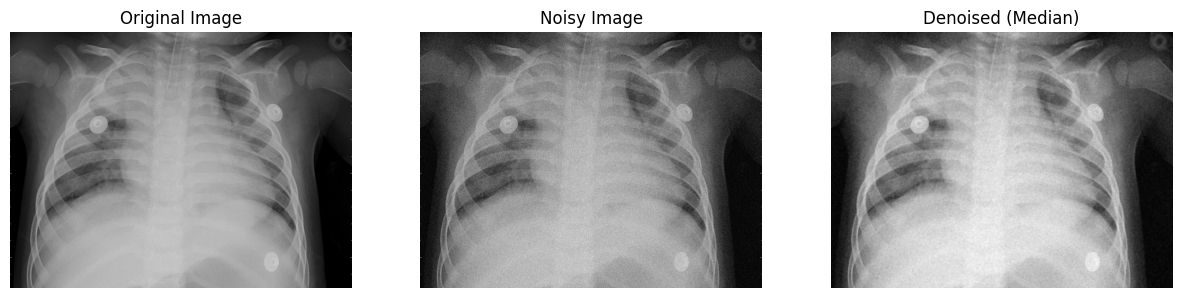

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define denoising methods
def apply_denoising(image, method):
    if method == "Mean":
        return cv2.blur(image, (5, 5))
    elif method == "Median":
        return cv2.medianBlur(image, 5)
    elif method == "Gaussian":
        return cv2.GaussianBlur(image, (5, 5), 2.5)
    elif method == "Bilateral":
        return cv2.bilateralFilter(image, 7, 50, 15)
    elif method == "Weiner":
        return wiener_filter(image)
    elif method == "Wavelet":
        return wavelet_denoise(image)
    elif method == "Fourier":
        return fourier_denoise(image)
    else:
        raise ValueError("Unknown method")

# Wiener filter
def wiener_filter(image):
    from scipy.signal import wiener
    filtered = wiener(image, (5, 5))
    filtered = np.nan_to_num(filtered, nan=0.0)
    return np.clip(filtered, 0, 255).astype(np.uint8)

# Wavelet denoising
def wavelet_denoise(image):
    import pywt
    coeffs = pywt.wavedec2(image, 'haar', level=2)
    coeffs_thresh = [coeffs[0]]
    for details in coeffs[1:]:
        coeffs_thresh.append(tuple(pywt.threshold(c, value=30, mode='soft') for c in details))
    return pywt.waverec2(coeffs_thresh, 'haar').astype(np.uint8)

# Fourier denoising
def fourier_denoise(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1
    fshift *= mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back).astype(np.uint8)

# Base folder paths
base_path = '/content/drive/MyDrive/CS415Project/chest_xray'
original_path = os.path.join(base_path, 'processed_train/train_all')
noisy_base_path = os.path.join(base_path, 'processed_train_noisy/train_all_noise')

# Denoising methods
methods = ["Mean", "Median", "Gaussian", "Bilateral", "Weiner", "Wavelet", "Fourier"]

# Output folder for comparisons
output_folder = os.path.join(base_path, 'individual-comparisons')
os.makedirs(output_folder, exist_ok=True)

# Process all images in the original and noisy folders
original_images = sorted(os.listdir(original_path))
noisy_images = sorted(os.listdir(noisy_base_path))

for orig_img_name, noisy_img_name in zip(original_images, noisy_images):
    orig_img_path = os.path.join(original_path, orig_img_name)
    noisy_img_path = os.path.join(noisy_base_path, noisy_img_name)

    orig_img = cv2.imread(orig_img_path, cv2.IMREAD_GRAYSCALE)
    noisy_img = cv2.imread(noisy_img_path, cv2.IMREAD_GRAYSCALE)

    if orig_img is None or noisy_img is None:
        print(f"Error loading images: {orig_img_name}, {noisy_img_name}")
        continue

    for method in methods:
        # Apply denoising method
        denoised_img = apply_denoising(noisy_img, method)

        # Prepare the figure for visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

        # Original image
        axes[0].imshow(orig_img, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Noisy image
        axes[1].imshow(noisy_img, cmap='gray')
        axes[1].set_title('Noisy Image')
        axes[1].axis('off')

        # Denoised image
        axes[2].imshow(denoised_img, cmap='gray')
        axes[2].set_title(f'Denoised ({method})')
        axes[2].axis('off')

        # Adjust spacing and save the figure
        plt.subplots_adjust(wspace=0.2)
        save_path = os.path.join(output_folder, f'{os.path.splitext(orig_img_name)[0]}_{method}.png')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        plt.close()

        print(f"Saved comparison for image '{orig_img_name}' with method '{method}' to {save_path}")
